In [1]:
import os
import time
import random
import gzip

import gurobipy as gp
from gurobipy import GRB 
import numpy as np
import pandas as pd
import torch
from torch import nn
from tqdm import tqdm

In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# Disable Gurobi output globally
gp.setParam("OutputFlag", 0)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-25


### Load Data

In [4]:
def getVarTypes(model):
    types = []
    for var in model.getVars():
        # classify as binary if integer with bounds [0, 1]
        if var.VType == GRB.INTEGER and var.LB == 0 and var.UB == 1:
            types.append(GRB.BINARY)
        else:
            types.append(var.VType)
    return types

def getObjVec(model):
    obj_vector = np.array([var.Obj for var in model.getVars()])
    return obj_vector

def getConstrMat(model):
    num_constraints = model.NumConstrs
    num_variables = model.NumVars
    A_matrix = np.zeros((num_constraints, num_variables))
    for i, constraint in enumerate(model.getConstrs()):
        # check the sense and adjust if necessary
        if constraint.Sense == GRB.GREATER_EQUAL:
            # multiply the constraint row and RHS by -1 to convert >= to <=
            row = model.getRow(constraint)
            for j in range(row.size()):
                var = row.getVar(j)
                col_index = var.index
                A_matrix[i, col_index] = -row.getCoeff(j)
        elif constraint.Sense == GRB.LESS_EQUAL:
            # keep <= constraints as they are
            row = model.getRow(constraint)
            for j in range(row.size()):
                var = row.getVar(j)
                col_index = var.index
                A_matrix[i, col_index] = row.getCoeff(j)
        else:
            # raise an error if an equality constraint is encountered
            raise ValueError(f"Equality constraint found in constraint {constraint.ConstrName}. This is not allowed.")
    return A_matrix

def getRhsVec(model):
    num_constraints = model.NumConstrs
    num_variables = model.NumVars
    b_vector = np.zeros(num_constraints)
    for i, constraint in enumerate(model.getConstrs()):
        # check the sense and adjust if necessary
        if constraint.Sense == GRB.GREATER_EQUAL:
            b_vector[i] = -constraint.RHS
        elif constraint.Sense == GRB.LESS_EQUAL:
            # keep <= constraints as they are
            b_vector[i] = constraint.RHS
        else:
            # raise an error if an equality constraint is encountered
            raise ValueError(f"Equality constraint found in constraint {constraint.ConstrName}. This is not allowed.")
    return b_vector

def getBounds(model):
    # lower bound
    lb_vector = np.array([var.LB for var in model.getVars()])
    # upper bound
    ub_vector = np.array([var.UB for var in model.getVars()])
    return lb_vector, ub_vector

In [5]:
# dir
data_dir = r".\data\datasets\vary_rhs\series_2"
# init data
b_data = np.zeros((50, 1250))
i = 0
# go through files
print("RHS vector for:")
for file_name in os.listdir(data_dir):
    if file_name.endswith(".mps.gz"):
        file_path = os.path.join(data_dir, file_name)
        # read file
        with gzip.open(file_path, "rb") as f:
            with open("temp.mps", "wb") as temp_file:
                temp_file.write(f.read())
        # load model
        model = gp.read("temp.mps")
        # print or process the RHS vector as needed
        rhs_vector = getRhsVec(model)
        b_data[i] = rhs_vector
        # counting
        i += 1
print(b_data)

RHS vector for:
[[-18.69   1.19 -11.95 ...   0.     0.     0.  ]
 [ -2.97  -3.11 -13.05 ...   0.     0.     0.  ]
 [ -3.29  -3.02 -13.03 ...   0.     0.     0.  ]
 ...
 [-17.73   0.93 -12.02 ...   0.     0.     0.  ]
 [-18.05   1.01 -11.99 ...   0.     0.     0.  ]
 [-18.37   1.1  -11.97 ...   0.     0.     0.  ]]


In [6]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(b_data, test_size=0.2, random_state=42)

In [7]:
# var type
types = getVarTypes(model)
# objective
c = getObjVec(model)
# constraint
A = getConstrMat(model)
# bound
lb, ub = getBounds(model)

In [8]:
# check if the first 500 variable types are identical
print("First 500 types:", types[:500])
# check if the first 500 lower bounds are identical
first_500_lb_consistent = np.all(lb[:500] == lb[0])
if first_500_lb_consistent:
    print("The first 500 lower bounds are identical.")
    print("Lower bound for first 500 variables:", lb[0])
else:
    print("The first 500 lower bounds are not identical.")
    print("First 500 lower bounds:", lb[:500])
# check if the first 250 upper bounds are identical
first_250_ub_consistent = np.all(ub[:500] == ub[0])
if first_250_ub_consistent:
    print("The first 500 upper bounds are identical.")
    print("Upper bound for first 500 variables:", ub[0])
else:
    print("The first 500 upper bounds are not identical.")
    print("First 500 upper bounds:", ub[:500])

print()

# check if the last 250 variable types are identical
print("Last 500 types:", types[-500:])
# check if the last 250 lower bounds are identical
last_500_lb_consistent = np.all(lb[-500:] == lb[-500])
if last_500_lb_consistent:
    print("The last 500 lower bounds are identical.")
    print("Lower bound for last 500 variables:", lb[-500])
else:
    print("The last 500 lower bounds are not identical.")
    print("Last 500 lower bounds:", lb[-500:])
# check if the last 250 upper bounds are identical
last_500_ub_consistent = np.all(ub[-500:] == ub[-500])
if last_500_ub_consistent:
    print("The last 500 upper bounds are identical.")
    print("Upper bound for last 500 variables:", ub[-500])
else:
    print("The last 500 upper bounds are not identical.")
    print("Last 500 upper bounds:", ub[-500:])

First 500 types: ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C

### Analysis

In [9]:
# find the maximum and minimum values for each column in b_data
train_data_col_max = np.max(train_data, axis=0)
train_data_col_min = np.min(train_data, axis=0)
print("Minimum values for each column in b_data:", train_data_col_min)
print("Maximum values for each column in b_data:", train_data_col_max)

Minimum values for each column in b_data: [-18.69  -3.11 -13.05 ...   0.     0.     0.  ]
Maximum values for each column in b_data: [ -2.97   1.19 -11.95 ...   0.     0.     0.  ]


In [10]:
# identify columns with all non-zero elements in b_data
non_zero_columns = np.all(train_data != 0, axis=0)
non_zero_column_indices = np.where(non_zero_columns)[0]  # Get the indices of columns with all non-zero elements
print("Indices of columns in b_data where all entries are non-zero:")
print(non_zero_column_indices)

Indices of columns in b_data where all entries are non-zero:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200
 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218
 219 220 221 222 223 224 225 226 227 228 229 230 231 233 234 23

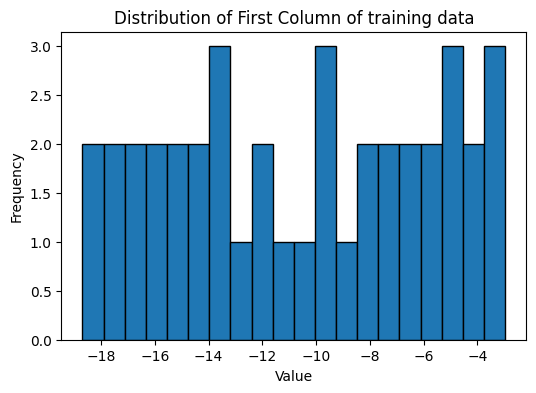

In [11]:
import matplotlib.pyplot as plt
# plot histogram for the a column
plt.figure(figsize=(6, 4))
plt.hist(train_data[:, 0], bins=20, edgecolor='black')
plt.title("Distribution of First Column of training data")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

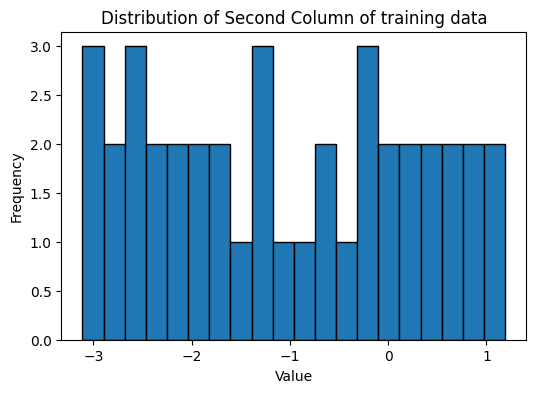

In [12]:
import matplotlib.pyplot as plt
# plot histogram for the a column of b_data
plt.figure(figsize=(6, 4))
plt.hist(train_data[:, 1], bins=20, edgecolor='black')
plt.title("Distribution of Second Column of training data")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

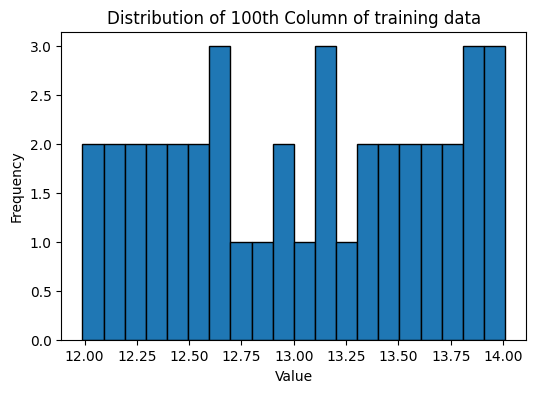

In [13]:
import matplotlib.pyplot as plt
# plot histogram for the a column of
plt.figure(figsize=(6, 4))
plt.hist(train_data[:, 99], bins=20, edgecolor='black')
plt.title("Distribution of 100th Column of training data")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

### Generate Samples

In [14]:
# sample size
sample_size = 8000
# init sample
train_sample = np.zeros((sample_size, train_data.shape[1]))
# get the column-wise max and min values from train_data
train_data_col_max = np.ceil(np.max(train_data, axis=0))[:250]
train_data_col_min = np.floor(np.min(train_data, axis=0))[:250]
# generate uniform random values for the first 250 rows between the min and max of each column
train_sample[:, :250] = np.random.uniform(train_data_col_min, train_data_col_max, (sample_size, 250))
# display the sampled b_sample array
print("Sampled b_sample array:")
print(train_sample)

Sampled b_sample array:
[[-1.26328180e+01  1.70428584e+00 -1.18040182e+01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.39943688e+01 -1.68941363e+00 -1.14465900e+01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-7.13125086e+00 -7.83421802e-01 -1.30714172e+01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [-9.46003224e+00 -2.02545317e+00 -1.12896774e+01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.20397859e+01  1.20947859e-02 -1.36297970e+01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.03376187e+01 -1.82784240e-01 -1.15633815e+01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


### Baseline 

In [15]:
def setRHS(model, b):
    # reset
    model.reset() 
    # update the RHS values
    for constr, new_rhs in zip(model.getConstrs(), b):
        constr.RHS = new_rhs

#### Exact Solver

In [16]:
# init model
model = gp.read("temp.mps")
# init df
params, sols, objvals, conviols, elapseds = [], [], [], [], []
for b in tqdm(test_data):
        # set rhs
        setRHS(model, b)
        # solve
        tick = time.time()
        model.optimize()
        tock = time.time()
        # record
        params.append(list(b[:250]))
        sols.append([var.x for var in model.getVars()])
        objvals.append(model.objVal)
        conviols.append(0)
        elapseds.append(tock - tick)
df = pd.DataFrame({"Param":params,
                    "Sol":sols,
                    "Obj Val": objvals,
                    "Constraints Viol": conviols,
                    "Elapsed Time": elapseds})
time.sleep(1)
print(df.describe())
print("Total elapsed time for optimization: {:.2f} seconds".format(df["Elapsed Time"].sum()))
df.to_csv("result/lp_exact_rhs-series2.csv")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:32<00:00,  3.27s/it]


            Obj Val  Constraints Viol  Elapsed Time
count     10.000000              10.0     10.000000
mean  -17169.485687               0.0      3.257836
std        1.269903               0.0      0.347903
min   -17171.525260               0.0      2.712321
25%   -17170.355450               0.0      3.022019
50%   -17169.264223               0.0      3.287408
75%   -17168.411405               0.0      3.404324
max   -17167.980247               0.0      3.987588
Total elapsed time for optimization: 32.58 seconds


#### N1 Hueristic

In [17]:
# init model
model = gp.read("temp.mps")
# limit to root node
model.setParam("SolutionLimit", 1) 
# init df
params, sols, objvals, conviols, elapseds = [], [], [], [], []
for b in tqdm(test_data):
        # set rhs
        setRHS(model, b)
        # solve
        tick = time.time()
        model.optimize()
        tock = time.time()
        # record
        params.append(list(b[:250]))
        sols.append([var.x for var in model.getVars()])
        objvals.append(model.objVal)
        conviols.append(0)
        elapseds.append(tock - tick)
df = pd.DataFrame({"Param":params,
                    "Sol":sols,
                    "Obj Val": objvals,
                    "Constraints Viol": conviols,
                    "Elapsed Time": elapseds})
time.sleep(1)
print(df.describe())
print("Total elapsed time for optimization: {:.2f} seconds".format(df["Elapsed Time"].sum()))
df.to_csv("result/lp_root_rhs-series2.csv")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.73it/s]


           Obj Val  Constraints Viol  Elapsed Time
count    10.000000              10.0     10.000000
mean  -7409.652066               0.0      0.168594
std       0.084518               0.0      0.009324
min   -7409.778049               0.0      0.158386
25%   -7409.713027               0.0      0.161828
50%   -7409.647334               0.0      0.168466
75%   -7409.586088               0.0      0.170633
max   -7409.530987               0.0      0.190636
Total elapsed time for optimization: 1.69 seconds


### Learning-to-Optimize

In [18]:
# hpyerparameters
batch_size = 64
hlayers_sol = 5
hlayers_rnd = 4
hsize = 256
lr = 1e-3
penalty_weight = 10000

In [19]:
from torch.utils.data import DataLoader
from neuromancer.dataset import DictDataset
# get dataset
data_train = DictDataset({"b":torch.from_numpy(train_sample[:,:250]).float()}, name="train")
data_val = DictDataset({"b":torch.from_numpy(train_data[:,:250]).float()}, name="train")
# set dataloader
loader_train = DataLoader(data_train, batch_size, num_workers=0,
                          collate_fn=data_train.collate_fn, shuffle=True)
loader_val   = DataLoader(data_val, batch_size, num_workers=0,
                          collate_fn=data_train.collate_fn, shuffle=True)

In [20]:
class penaltyLoss(nn.Module):
    """
    Penalty loss function for linear optimization problems.
    """
    def __init__(self, input_keys, A, c, lb, ub, penalty_weight=50, output_key="loss"):
        """
        Initialize penalty loss with problem parameters.
        """
        super().__init__()
        self.b_key, self.x_key = input_keys
        self.output_key = output_key
        self.penalty_weight = penalty_weight
        self.device = None
        # fixed coefficients
        self.A = torch.from_numpy(A).float()
        self.c = torch.from_numpy(c).float()
        self.lb = torch.from_numpy(lb).float()
        self.ub = torch.from_numpy(ub).float()

    def forward(self, input_dict):
        """
        Forward pass to compute the penalty loss.
        """
        # objective function calculation
        obj_value = self.cal_obj(input_dict)
        # constraint violation calculation
        viol_value = self.cal_constr_viol(input_dict)
        # penalized loss
        loss = obj_value + self.penalty_weight * viol_value
        # mean loss
        input_dict[self.output_key] = torch.mean(loss)
        return input_dict

    def cal_obj(self, input_dict):
        """
        Calculate the linear objective function.
        """
        x = input_dict[self.x_key]
        # move parameters to the correct device if not already set
        if self.device is None:
            self.device = x.device
            self.c = self.c.to(self.device)
            self.A = self.A.to(self.device)
            self.lb = self.lb.to(self.device)
            self.ub = self.ub.to(self.device)
        # calculate c^T x for the objective
        obj_term = torch.einsum("n,bn->b", self.c, x)
        return obj_term

    def cal_constr_viol(self, input_dict):
        """
        Calculate constraint and bounds violations.
        """
        x, b = input_dict[self.x_key], input_dict[self.b_key]
        # fill 0 for rhs
        b = torch.cat([b, torch.zeros(b.shape[0], self.A.shape[0] - b.shape[1], device=b.device)], dim=1)
        # calculate constraint violations (Ax <= b)
        lhs = torch.einsum("mn,bn->bm", self.A, x)  # Ax
        constr_violation = (torch.relu(lhs - b + 1e-3) ** 2).sum(dim=1)  # Max(0, Ax - b)
        # calculate bounds violations
        lower_violation = (torch.relu(self.lb - x + 1e-3) ** 2).sum(dim=1)  # x >= lb
        upper_violation = (torch.relu(x - self.ub + 1e-3) ** 2).sum(dim=1)  # x <= ub
        return constr_violation + lower_violation + upper_violation

    def get_constr_viol(self, input_dict):
        """
        Calculate constraint and bounds violations.
        """
        x, b = input_dict[self.x_key], input_dict[self.b_key]
        # fill 0 for rhs
        b = torch.cat([b, torch.zeros(b.shape[0], self.A.shape[0] - b.shape[1], device=b.device)], dim=1)
        # calculate constraint violations (Ax <= b)
        lhs = torch.einsum("mn,bn->bm", self.A, x)  # Ax
        constr_violation = torch.relu(lhs - b - 1e-5).sum(dim=1)  # Max(0, Ax - b)
        # calculate bounds violations
        lower_violation = torch.relu(self.lb - x - 1e-5).sum(dim=1)  # x >= lb
        upper_violation = torch.relu(x - self.ub - 1e-5).sum(dim=1)  # x <= ub
        return constr_violation + lower_violation + upper_violation

#### Rounding Classification

In [21]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [22]:
import neuromancer as nm
from src.func.layer import netFC
from src.func import roundGumbelModel
# build neural architecture for the solution map
func = nm.modules.blocks.MLP(insize=250, outsize=model.NumVars, bias=True,
                             linear_map=nm.slim.maps["linear"],
                             nonlin=nn.ReLU, hsizes=[hsize]*hlayers_sol)
smap = nm.system.Node(func, ["b"], ["x"], name="smap")
# define rounding model
layers_rnd = netFC(input_dim=250+model.NumVars,
                   hidden_dims=[hsize]*hlayers_rnd,
                   output_dim=model.NumVars)
rnd = roundGumbelModel(layers=layers_rnd, param_keys=["b"], var_keys=["x"],
                       output_keys=["x_rnd"], bin_ind={"x":range(500,1000)},
                       continuous_update=True, name="round")
# build neuromancer problem for rounding
components = nn.ModuleList([smap, rnd]).to("cuda")
loss_fn = penaltyLoss(["b", "x_rnd"], A, c, lb, ub, penalty_weight)

In [23]:
from src.problem.neuromancer.trainer import trainer
# training
epochs = 200                    # number of training epochs
warmup = 20                    # number of epochs to wait before enacting early stopping policy
patience = 20                   # number of epochs with no improvement in eval metric to allow before early stopping
optimizer = torch.optim.AdamW(components.parameters(), lr=lr)
# create a trainer for the problem
my_trainer = trainer(components, loss_fn, optimizer, epochs=epochs, patience=patience, warmup=warmup, device="cuda")
# training for the rounding problem
my_trainer.train(loader_train, loader_val)

Epoch 0, Iters 0, Validation Loss: 601187648.00
Epoch 0, Iters 125, Training Loss: 769436819.87, Validation Loss: 1451151232.00
Epoch 1, Iters 250, Training Loss: 36093297.65, Validation Loss: 46055456.00
Epoch 2, Iters 375, Training Loss: 14153777.38, Validation Loss: 8747938.00
Epoch 3, Iters 500, Training Loss: 6867552.38, Validation Loss: 9504016.00
Epoch 4, Iters 625, Training Loss: 3285779.23, Validation Loss: 3090753.25
Epoch 5, Iters 750, Training Loss: 1521221.94, Validation Loss: 42051548.00
Epoch 6, Iters 875, Training Loss: 968295.46, Validation Loss: 377280.66
Epoch 7, Iters 1000, Training Loss: 532239.75, Validation Loss: 198019.66
Epoch 8, Iters 1125, Training Loss: 417240.98, Validation Loss: 184068.78
Epoch 9, Iters 1250, Training Loss: 274862.18, Validation Loss: 70756.57
Epoch 10, Iters 1375, Training Loss: 165707.97, Validation Loss: 158303.98
Epoch 11, Iters 1500, Training Loss: 173569.90, Validation Loss: 31555.00
Epoch 12, Iters 1625, Training Loss: 116210.98, Va

In [24]:
# init model
model = gp.read("temp.mps")
# init df
params, sols, objvals, conviols, elapseds = [], [], [], [], []
for b in tqdm(test_data):
    # data point as tensor
    datapoints = {"b": torch.unsqueeze(torch.tensor(b).float()[:250], 0).to("cuda"),
                  "name": "test"}
    # infer
    components.eval()
    tick = time.time()
    with torch.no_grad():
        for comp in components:
            datapoints.update(comp(datapoints))
    tock = time.time()
    # get solutions
    x_val = datapoints["x_rnd"][0].detach().cpu().numpy()
    params.append(list(b))
    sols.append(list(x_val))
    objvals.append(c@x_val)
    conviols.append(loss_fn.get_constr_viol(datapoints)[0].item())
    elapseds.append(tock - tick)
df = pd.DataFrame({"Param":params,
                   "Sol":sols,
                   "Obj Val": objvals,
                   "Constraints Viol": conviols,
                   "Elapsed Time": elapseds})
time.sleep(1)
print(df.describe())
print("Total elapsed time for optimization: {:.2f} seconds".format(df["Elapsed Time"].sum()))
print("Number of infeasible solution: {}".format(np.sum(df["Constraints Viol"] > 0)))
df.to_csv("result/lp_cls_rhs-series2-g.csv")

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 168.22it/s]


            Obj Val  Constraints Viol  Elapsed Time
count     10.000000         10.000000     10.000000
mean  -11333.951053          2.676047      0.003862
std       18.172082          0.015114      0.000707
min   -11359.429729          2.655293      0.003012
25%   -11350.034075          2.663533      0.003518
50%   -11331.907742          2.673794      0.003676
75%   -11320.323254          2.689656      0.004097
max   -11306.742206          2.698342      0.005028
Total elapsed time for optimization: 0.04 seconds
Number of infeasible solution: 10


#### Learnable Threshold

In [25]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [26]:
import neuromancer as nm
from src.func.layer import netFC
from src.func import roundThresholdModel
# build neural architecture for the solution map
func = nm.modules.blocks.MLP(insize=250, outsize=model.NumVars, bias=True,
                             linear_map=nm.slim.maps["linear"],
                             nonlin=nn.ReLU, hsizes=[hsize]*hlayers_sol)
smap = nm.system.Node(func, ["b"], ["x"], name="smap")
# define rounding model
layers_rnd = netFC(input_dim=250+model.NumVars,
                   hidden_dims=[hsize]*hlayers_rnd,
                   output_dim=model.NumVars)
rnd = roundThresholdModel(layers=layers_rnd, param_keys=["b"], var_keys=["x"],
                         output_keys=["x_rnd"], bin_ind={"x":range(500,1000)},
                         continuous_update=True, name="round")
# build neuromancer problem for rounding
components = nn.ModuleList([smap, rnd]).to("cuda")
loss_fn = penaltyLoss(["b", "x_rnd"], A, c, lb, ub, penalty_weight)

In [27]:
from src.problem.neuromancer.trainer import trainer
# training
epochs = 200                    # number of training epochs
warmup = 20                     # number of epochs to wait before enacting early stopping policy
patience = 20                   # number of epochs with no improvement in eval metric to allow before early stopping
optimizer = torch.optim.AdamW(components.parameters(), lr=lr)
# create a trainer for the problem
my_trainer = trainer(components, loss_fn, optimizer, epochs=epochs, patience=patience, warmup=warmup, device="cuda")
# training for the rounding problem
my_trainer.train(loader_train, loader_val)

Epoch 0, Iters 0, Validation Loss: 1047256512.00
Epoch 0, Iters 125, Training Loss: 861665818.21, Validation Loss: 743262016.00
Epoch 1, Iters 250, Training Loss: 22711112.84, Validation Loss: 28392884.00
Epoch 2, Iters 375, Training Loss: 19093492.72, Validation Loss: 24249974.00
Epoch 3, Iters 500, Training Loss: 17753963.19, Validation Loss: 16812390.00
Epoch 4, Iters 625, Training Loss: 17025906.93, Validation Loss: 14264760.00
Epoch 5, Iters 750, Training Loss: 15740293.45, Validation Loss: 18601678.00
Epoch 6, Iters 875, Training Loss: 15540812.70, Validation Loss: 14715095.00
Epoch 7, Iters 1000, Training Loss: 14162799.63, Validation Loss: 15365587.00
Epoch 8, Iters 1125, Training Loss: 13784575.11, Validation Loss: 19018206.00
Epoch 9, Iters 1250, Training Loss: 13618960.65, Validation Loss: 13296845.00
Epoch 10, Iters 1375, Training Loss: 14296776.69, Validation Loss: 17406864.00
Epoch 11, Iters 1500, Training Loss: 14135208.07, Validation Loss: 14638888.00
Epoch 12, Iters 16

In [28]:
# init model
model = gp.read("temp.mps")
# init df
params, sols, objvals, conviols, elapseds = [], [], [], [], []
for b in tqdm(test_data):
    # data point as tensor
    datapoints = {"b": torch.unsqueeze(torch.tensor(b).float()[:250], 0).to("cuda"),
                  "name": "test"}
    # infer
    components.eval()
    tick = time.time()
    with torch.no_grad():
        for comp in components:
            datapoints.update(comp(datapoints))
    tock = time.time()
    # get solutions
    x_val = datapoints["x_rnd"][0].detach().cpu().numpy()
    params.append(list(b))
    sols.append(list(x_val))
    objvals.append(c@x_val)
    conviols.append(loss_fn.get_constr_viol(datapoints)[0].item())
    elapseds.append(tock - tick)
df = pd.DataFrame({"Param":params,
                   "Sol":sols,
                   "Obj Val": objvals,
                   "Constraints Viol": conviols,
                   "Elapsed Time": elapseds})
time.sleep(1)
print(df.describe())
print("Total elapsed time for optimization: {:.2f} seconds".format(df["Elapsed Time"].sum()))
print("Number of infeasible solution: {}".format(np.sum(df["Constraints Viol"] > 0)))
df.to_csv("result/lp_thd_rhs-series2.csv")

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 189.65it/s]


          Obj Val  Constraints Viol  Elapsed Time
count   10.000000         10.000000     10.000000
mean  -312.363269        127.734721      0.003879
std     50.710645         19.449343      0.000815
min   -386.408176        106.318130      0.002999
25%   -339.847469        115.801147      0.003105
50%   -318.915877        120.883945      0.003754
75%   -267.270809        141.723131      0.004454
max   -243.263057        160.700272      0.005169
Total elapsed time for optimization: 0.04 seconds
Number of infeasible solution: 10
